# Computer Vision 2024 Assignment 3: Deep Learning for Perception Tasks

This assignment contains 2 questions. The first question probes understanding of deep learning for classification. The second question is a more challenging classification experiment on a larger dataset. Answer the questions in separate Python notebooks.

## Question 1: A simple classifier, 20 marks

For this exercise, we provide demo code showing how to train a network on a small dataset called [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist). Please run through the code "tutorial-style" to get a sense of what it is doing. Then use the code alongside lecture notes and other resources to understand how to use pytorch libraries to implement, train and use a neural network.

For the Fashion-MNIST dataset the lables from 0-9 correspond to various clothing classes so you might find it convenient to create a python list as follows:

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

You will need to answer various questions about the system, how it operates, the results of experiments with it and make modifications to it yourself. You can change the training scheme and the network structure. 

Organize your own text and code cell to show the answer of each questions.

Detailed requirements:

**Q1.1 (1 point)**

Extract 3 images of different types of clothing from the training dataset, print out the size/shape of the training images, and display the three with their corresponding labels. 

**Q1.2 (2 points)** 

Run the training code for 10 epochs, for different values of the learning rate. Fill in the table below and plot the loss curves for each experiment:

|Lr|Accuracy|
|---|---|
|1   |      |
|0.1|          |
|0.01|         |
|0.001  |        |


**Q1.3 (3 points)** 

Report the number of epochs when the accuracy reaches 85%. Fill in the table below and plot the loass curve for each experiment:

|Lr|Accuracy|Epoch|
|---|---|---|
|1   |      |     |
|0.1|          |    |
|0.01|         |    |
|0.001  |        |     |


**Q1.4 (2 points)** 

Compare the results in table 1 and table 2, what is your observation and your understanding of learning rate?


**Q1.5 (5 points)** 

Build a wider network by modifying the code that constructs the network so that the hidden layer(s) contain more perceptrons, and record the accuracy along with the number of trainable parameters in your model.  Now modify the oroginal network to be deeper instead of wider (i.e. by adding more hidden layers). Record your accuracy and network size findings. Plot the loss curve for each experiment. Write down your conclusions about changing the network structure?  

|Structures|Accuracy|Parameters|
|---|---|---|
|Base   |      ||
|Deeper|          ||
|Wider|         ||


**Q1.6 (2 points)** 

Calculate the mean of the gradients of the loss to all trainable parameters. Plot the gradients curve for the first 100 training steps. What are your observations? Note that this gradients will be saved with the training weight automatically after you call loss.backwards(). Hint: the mean of the gradients decrease.

For more exlanation of q1.7, you could refer to the following simple instructions: https://colab.research.google.com/drive/1XAsyNegGSvMf3_B6MrsXht7-fHqtJ7OW?usp=sharing

**Q1.7 (5 points)** 

Modify the network structure and training/test to use a small convolutional neural network instead of an MLP. Discuss your findings with rehgard to convergence, accuracy and number of parameters, relative to MLPs.  

Hint: Look at the structure of the CNN in the Workshop 3 examples.

In [2]:
import numpy as np # This is for mathematical operations

# this is used in plotting 
import matplotlib.pyplot as plt 
import time
import pylab as pl
from IPython import display

%matplotlib inline

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [4]:
#### Tutorial Code
####PyTorch has two primitives to work with data: torch.utils.data.DataLoader and torch.utils.data.Dataset. 
#####Dataset stores samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset.
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

# Download training data from open datasets. 
##Every TorchVision Dataset includes two arguments: 
##transform and target_transform to modify the samples and labels respectively.

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

**NOTE**: For consistency with the original data set, we call our validation data "test_data". It is important to keep in mind though that we are using the data for model validation and not for testing the final, trained model (which requires data not used when training the model parameters). 

We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset and supports automatic batching, sampling, shuffling, and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [5]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


Add in a code cell to inspect the training data, as per Q1.1. Each element of the training_data structure has a greyscale image (which you can use plt.imshow(img[0,:,:]) to display, just like you did in previous assignments.  

In [6]:
label_defs = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

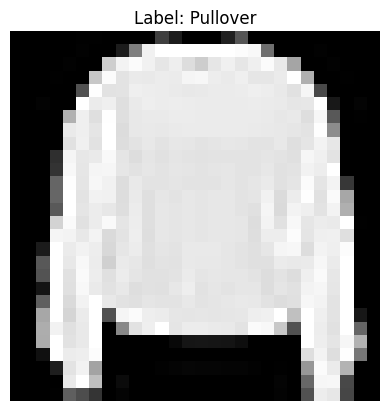

Shape: torch.Size([28, 28])




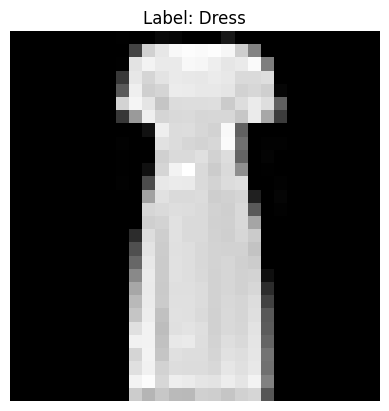

Shape: torch.Size([28, 28])




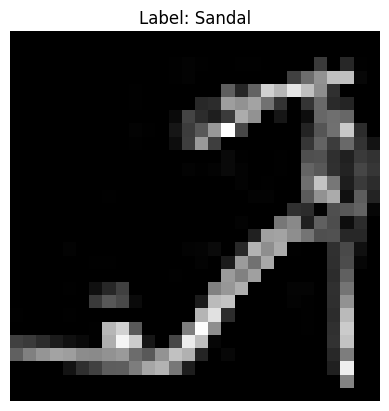

Shape: torch.Size([28, 28])




In [7]:
# Code cell for training image display
images, labels = next(iter(train_dataloader))

import random
training_indices = random.sample(range(batch_size), 3)

training_images = [(images[index][0,:,:], labels[index]) for index in training_indices]

for image in training_images:
    plt.imshow(image[0], cmap="gray")
    plt.title(f"Label: {label_defs[int(image[1])]}")
    plt.axis("off")
    plt.show()
    print(f"Shape: {image[0].shape}")
    print("\n")

To define a neural network in PyTorch, we create a class that inherits from nn.Module. We define the layers of the network in the init function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the GPU if available.

In [8]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

import torch.nn.functional as F

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
       )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [9]:
###Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.

In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        train_loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = train_loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return train_loss.item()

In [15]:
##Define a test function
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss, correct

In [12]:
#Train and test the model
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")



Epoch 1
-------------------------------
loss: 2.313962  [    0/60000]
loss: 2.297545  [ 6400/60000]
loss: 2.275954  [12800/60000]
loss: 2.271981  [19200/60000]
loss: 2.243721  [25600/60000]
loss: 2.218681  [32000/60000]
loss: 2.225700  [38400/60000]
loss: 2.188680  [44800/60000]
loss: 2.202540  [51200/60000]
loss: 2.152753  [57600/60000]
Test Error: 
 Accuracy: 40.1%, Avg loss: 2.153900 

Epoch 2
-------------------------------
loss: 2.171386  [    0/60000]
loss: 2.157628  [ 6400/60000]
loss: 2.090374  [12800/60000]
loss: 2.111733  [19200/60000]
loss: 2.052832  [25600/60000]
loss: 1.992427  [32000/60000]
loss: 2.016853  [38400/60000]
loss: 1.928779  [44800/60000]
loss: 1.956305  [51200/60000]
loss: 1.872537  [57600/60000]
Test Error: 
 Accuracy: 54.5%, Avg loss: 1.870221 

Epoch 3
-------------------------------
loss: 1.909613  [    0/60000]
loss: 1.877293  [ 6400/60000]
loss: 1.742288  [12800/60000]
loss: 1.798452  [19200/60000]
loss: 1.685862  [25600/60000]
loss: 1.634405  [32000/600

## 1.2

Training for 10 epochs with learning rate: 1
Epoch 1
-------------------------------
loss: 2.304365  [    0/60000]
loss: 2.328381  [ 6400/60000]
loss: 2.105218  [12800/60000]
loss: 1.715568  [19200/60000]
loss: 1.808466  [25600/60000]
loss: 1.918949  [32000/60000]
loss: 2.043715  [38400/60000]
loss: 2.234220  [44800/60000]
loss: 2.022423  [51200/60000]
loss: 1.624066  [57600/60000]
Test Error: 
 Accuracy: 20.8%, Avg loss: 1.730494 

Epoch 2
-------------------------------
loss: 1.711871  [    0/60000]
loss: 1.715808  [ 6400/60000]
loss: 2.993676  [12800/60000]
loss: 1.925768  [19200/60000]
loss: 2.150454  [25600/60000]
loss: 2.327453  [32000/60000]
loss: 2.700418  [38400/60000]
loss: 1.738425  [44800/60000]
loss: 2.133238  [51200/60000]
loss: 1.787003  [57600/60000]
Test Error: 
 Accuracy: 19.8%, Avg loss: 1.748795 

Epoch 3
-------------------------------
loss: 1.826433  [    0/60000]
loss: 1.710266  [ 6400/60000]
loss: 1.757244  [12800/60000]
loss: 1.693216  [19200/60000]
loss: 1.650

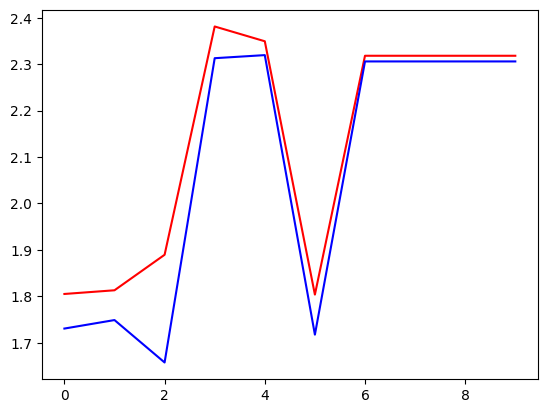

Done!

Training for 10 epochs with learning rate: 0.1
Epoch 1
-------------------------------
loss: 2.308367  [    0/60000]
loss: 0.888367  [ 6400/60000]
loss: 0.586592  [12800/60000]
loss: 0.703018  [19200/60000]
loss: 0.620495  [25600/60000]
loss: 0.520869  [32000/60000]
loss: 0.547633  [38400/60000]
loss: 0.597101  [44800/60000]
loss: 0.621001  [51200/60000]
loss: 0.465364  [57600/60000]
Test Error: 
 Accuracy: 79.4%, Avg loss: 0.541165 

Epoch 2
-------------------------------
loss: 0.420073  [    0/60000]
loss: 0.434173  [ 6400/60000]
loss: 0.378243  [12800/60000]
loss: 0.434942  [19200/60000]
loss: 0.405638  [25600/60000]
loss: 0.458123  [32000/60000]
loss: 0.420697  [38400/60000]
loss: 0.505812  [44800/60000]
loss: 0.508899  [51200/60000]
loss: 0.438569  [57600/60000]
Test Error: 
 Accuracy: 82.9%, Avg loss: 0.460612 

Epoch 3
-------------------------------
loss: 0.318214  [    0/60000]
loss: 0.358400  [ 6400/60000]
loss: 0.317669  [12800/60000]
loss: 0.359180  [19200/60000]
lo

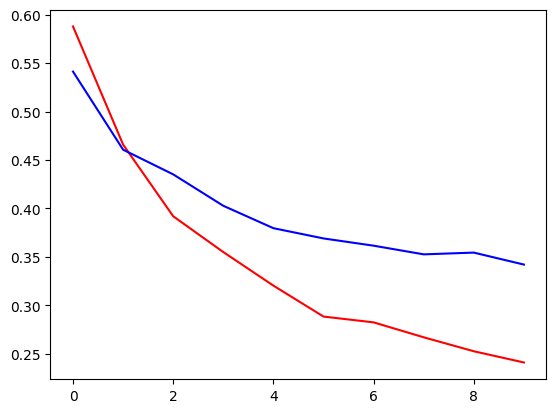

Done!

Training for 10 epochs with learning rate: 0.01
Epoch 1
-------------------------------
loss: 2.303275  [    0/60000]
loss: 2.162216  [ 6400/60000]
loss: 1.804335  [12800/60000]
loss: 1.493639  [19200/60000]
loss: 1.135106  [25600/60000]
loss: 1.043159  [32000/60000]
loss: 0.997604  [38400/60000]
loss: 0.878792  [44800/60000]
loss: 0.873346  [51200/60000]
loss: 0.810385  [57600/60000]
Test Error: 
 Accuracy: 71.5%, Avg loss: 0.788875 

Epoch 2
-------------------------------
loss: 0.791086  [    0/60000]
loss: 0.849768  [ 6400/60000]
loss: 0.592420  [12800/60000]
loss: 0.782450  [19200/60000]
loss: 0.662914  [25600/60000]
loss: 0.638320  [32000/60000]
loss: 0.709882  [38400/60000]
loss: 0.698763  [44800/60000]
loss: 0.705608  [51200/60000]
loss: 0.644159  [57600/60000]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.632808 

Epoch 3
-------------------------------
loss: 0.567559  [    0/60000]
loss: 0.662655  [ 6400/60000]
loss: 0.447909  [12800/60000]
loss: 0.666438  [19200/60000]
l

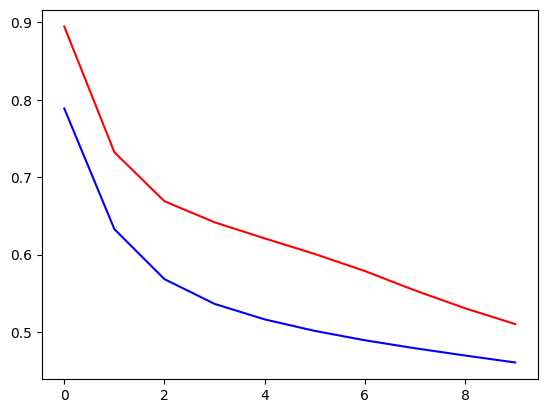

Done!

Training for 10 epochs with learning rate: 0.001
Epoch 1
-------------------------------
loss: 2.313265  [    0/60000]
loss: 2.294007  [ 6400/60000]
loss: 2.275147  [12800/60000]
loss: 2.259056  [19200/60000]
loss: 2.250085  [25600/60000]
loss: 2.223442  [32000/60000]
loss: 2.228765  [38400/60000]
loss: 2.196434  [44800/60000]
loss: 2.196541  [51200/60000]
loss: 2.157195  [57600/60000]
Test Error: 
 Accuracy: 41.3%, Avg loss: 2.155019 

Epoch 2
-------------------------------
loss: 2.175595  [    0/60000]
loss: 2.154885  [ 6400/60000]
loss: 2.099370  [12800/60000]
loss: 2.106852  [19200/60000]
loss: 2.056297  [25600/60000]
loss: 2.003769  [32000/60000]
loss: 2.030061  [38400/60000]
loss: 1.953645  [44800/60000]
loss: 1.960590  [51200/60000]
loss: 1.879171  [57600/60000]
Test Error: 
 Accuracy: 55.3%, Avg loss: 1.882889 

Epoch 3
-------------------------------
loss: 1.922676  [    0/60000]
loss: 1.881266  [ 6400/60000]
loss: 1.769918  [12800/60000]
loss: 1.807429  [19200/60000]


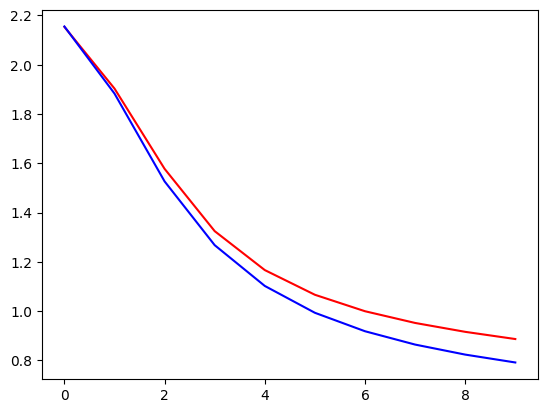

Done!



In [14]:
#Train and test the model
epochs = 10

learning_rates = [1, 1e-1, 1e-2, 1e-3]

for rate in learning_rates:
    print(f"Training for {epochs} epochs with learning rate: {rate}")
    model = NeuralNetwork().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=rate)

    train_losses = []
    test_losses = []

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss = train(train_dataloader, model, loss_fn, optimizer)
        test_loss, _ = test(test_dataloader, model, loss_fn)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

    plt.plot(np.array(train_losses), 'r')
    plt.plot(np.array(test_losses), 'b')
    plt.show()

    print("Done!\n")

|Lr|Accuracy|
|---|---|
|1   |    10%  |
|0.1|     87.5%   |
|0.01|     83.3%    |
|0.001  |    70.3%  |

## 1.3

In [17]:
#Train and test the model
learning_rates = [1, 1e-1, 1e-2, 1e-3]

for rate in learning_rates:
    print(f"Training for {epochs} epochs with learning rate: {rate}")
    model = NeuralNetwork().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=rate)

    train_losses = []
    test_losses = []

    epoch = 0
    while True:
        print(f"Epoch {epoch+1}\n-------------------------------")
        train_loss = train(train_dataloader, model, loss_fn, optimizer)
        test_loss, accuracy = test(test_dataloader, model, loss_fn)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        if accuracy >= 0.85:
            break
        
        epoch += 1

    plt.plot(np.array(train_losses), 'r')
    plt.plot(np.array(test_losses), 'b')
    plt.show()

    print(f"Got accuracy {(100*accuracy):>0.1f}% in {epoch + 1} epochs")

Training for 10 epochs with learning rate: 1
Epoch 1
-------------------------------
loss: 2.325193  [    0/60000]
loss: 2.109045  [ 6400/60000]
loss: 2.084603  [12800/60000]
loss: 1.902800  [19200/60000]
loss: 2.089154  [25600/60000]
loss: 1.832770  [32000/60000]
loss: 3.302176  [38400/60000]
loss: 1.534171  [44800/60000]
loss: 2.005812  [51200/60000]
loss: 2.330876  [57600/60000]
Test Error: 
 Accuracy: 10.4%, Avg loss: 2.300345 

Epoch 2
-------------------------------
loss: 2.281479  [    0/60000]
loss: 2.288582  [ 6400/60000]
loss: 2.313736  [12800/60000]
loss: 2.294784  [19200/60000]
loss: 1.894830  [25600/60000]
loss: 1.574697  [32000/60000]
loss: 2.747790  [38400/60000]
loss: 1.714780  [44800/60000]
loss: 1.825543  [51200/60000]
loss: 1.725100  [57600/60000]
Test Error: 
 Accuracy: 26.3%, Avg loss: 1.629971 

Epoch 3
-------------------------------
loss: 1.594557  [    0/60000]
loss: 1.511914  [ 6400/60000]
loss: 1.738479  [12800/60000]
loss: 1.772553  [19200/60000]
loss: 1.617

KeyboardInterrupt: 